## Install dependencies

## Imports

In [42]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [43]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [44]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [45]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [46]:
conditions = ['human', 'chimp', 'macaque', 'spatial_libd_human']
cond_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue']
color_dict = {'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'spatial_libd_human': 'tab:blue'}

# Load files

## Pseudobulks

### Load

In [47]:
dir_path = '../data/pseudobulks/'

In [48]:
os.listdir(dir_path)

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'pb_age.h5ad',
 'pb_age_sample_norm.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [49]:
adata_pb = sc.read_h5ad(dir_path + 'pb_mammals.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 94 × 14963
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

## Marker genes

In [50]:
with open('results/markers.txt', 'r') as file:
    # load genesets
    marker_genes = list(map(lambda x: x.strip().split('\t\t'), file.readlines()))
    # filter out mouse genesets
    marker_genes = {el[0]:el[1].split('\t') for el in marker_genes if 'Human' in el[0]}

len(marker_genes)

222

## Background genes

In [51]:
with open('results/background_genes.txt', 'r') as file:
    background_genes = file.read().split(',')

# Enrichment analysis

## Preprocess data

Let's make pandas dataframe with expression data and leave only well-expressed genes

In [52]:
df_ssgsea = pd.DataFrame(adata_pb.X, columns=adata_pb.var_names, index=adata_pb.obs_names)
df_ssgsea = df_ssgsea[background_genes]

sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df_ssgsea.loc[df_ssgsea.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df_ssgsea = df_ssgsea.loc[sample_order['all']]

df_ssgsea.head()

,A1BG,AACS,AADAT,AAGAB,AAK1,AAMP,AAR2,AARS1,AASDHPPT,AATF,...,ZSCAN26,ZSWIM6,ZSWIM7,ZSWIM8,ZUP1,ZWILCH,ZYG11B,ZYX,ZZEF1,ZZZ3
human_759_WM,0.186047,0.155039,0.069767,0.081395,0.236434,0.213178,0.050388,0.228682,0.437984,0.027132,...,0.042636,0.085271,0.062016,0.077519,0.034884,0.096899,0.337209,0.124031,0.023256,0.046512
human_j12_WM,0.061433,0.052560,0.030034,0.027986,0.163140,0.113993,0.032765,0.098976,0.255973,0.039590,...,0.020478,0.079863,0.040956,0.044369,0.032082,0.023891,0.283959,0.082594,0.018430,0.055973
human_j3_WM,0.122390,0.053276,0.056875,0.042477,0.120950,0.131030,0.051116,0.050396,0.251260,0.051116,...,0.017999,0.107271,0.047516,0.043197,0.056875,0.046796,0.307415,0.137509,0.049676,0.045356
human_j4_WM,0.090780,0.075177,0.035461,0.034043,0.139007,0.110638,0.065248,0.130496,0.245390,0.034043,...,0.022695,0.056738,0.048227,0.048227,0.032624,0.041135,0.243972,0.113475,0.026950,0.042553
human_j6_WM,0.048913,0.048913,0.035326,0.029891,0.150815,0.122283,0.042120,0.062500,0.342391,0.038043,...,0.024457,0.081522,0.048913,0.054348,0.058424,0.055707,0.263587,0.123641,0.019022,0.040761


## ssGSEA

In [53]:
ss = gseapy.ssgsea(
    data=df_ssgsea.T,
    gene_sets='Allen_Brain_Atlas_10x_scRNA_2021',
    outdir=None,
    min_size=3,
    sample_norm_method="rank",
    no_plot=True
)
ssGSEA_res = ss.res2d
ssGSEA_res.head()

,Name,Term,ES,NES
0,human_j12_L2,Mouse 203 L5 IT CTX down,3533.690498,0.502764
1,human_j6_L1,Mouse 203 L5 IT CTX down,3512.209785,0.499708
2,macaque_nb0904_L6,Human Inh L5-6 PVALB SST CRHR2 down,-3494.840552,-0.497236
3,macaque_0701_L4,Human Inh L5-6 PVALB SST CRHR2 down,-3486.028866,-0.495983
4,chimp_j8_L4,Human Inh L5-6 PVALB SST CRHR2 down,-3463.563848,-0.492786


We will work with normalized score from now on

In [54]:
nes = ssGSEA_res.pivot(index='Term', columns='Name', values='NES').astype(float)
nes = nes.loc[(nes.index.str.contains('Human')) & (nes.index.str.contains('up')), sample_order['all']]
nes.head(2)

Name,human_759_WM,human_j12_WM,human_j3_WM,human_j4_WM,human_j6_WM,human_759_L1,human_j12_L1,human_j3_L1,human_j4_L1,human_j6_L1,...,macaque_0704_L4,macaque_nb0904_L4,macaque_0701_L5,macaque_0703_L5,macaque_0704_L5,macaque_nb0904_L5,macaque_0701_L6,macaque_0703_L6,macaque_0704_L6,macaque_nb0904_L6
Term,,,,,,,,,,,,,,,,,,,,,
Human Astro L1 FGFR3 SERPINI2 up,0.186099,0.268805,0.210575,0.228810,0.167210,0.288363,0.269120,0.183924,0.210481,0.199831,...,0.029622,0.002814,0.042355,0.038128,0.020183,0.017079,0.115488,0.066658,0.040770,0.048492
Human Astro L1-6 FGFR3 AQP1 up,0.299863,0.327539,0.350029,0.329543,0.295422,0.361345,0.326417,0.309652,0.324569,0.324380,...,0.149955,0.091245,0.148656,0.148365,0.132798,0.104696,0.210441,0.180173,0.159167,0.145121


In [55]:
adata_ssgsea = an.AnnData(nes.T, obs=adata_pb.obs.loc[sample_order['all']])
adata_ssgsea

AnnData object with n_obs × n_vars = 94 × 104
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'

In [56]:
sc.pp.pca(adata_ssgsea)

computing PCA
    with n_comps=50
    finished (0:00:00)


computing PCA
    with n_comps=34
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


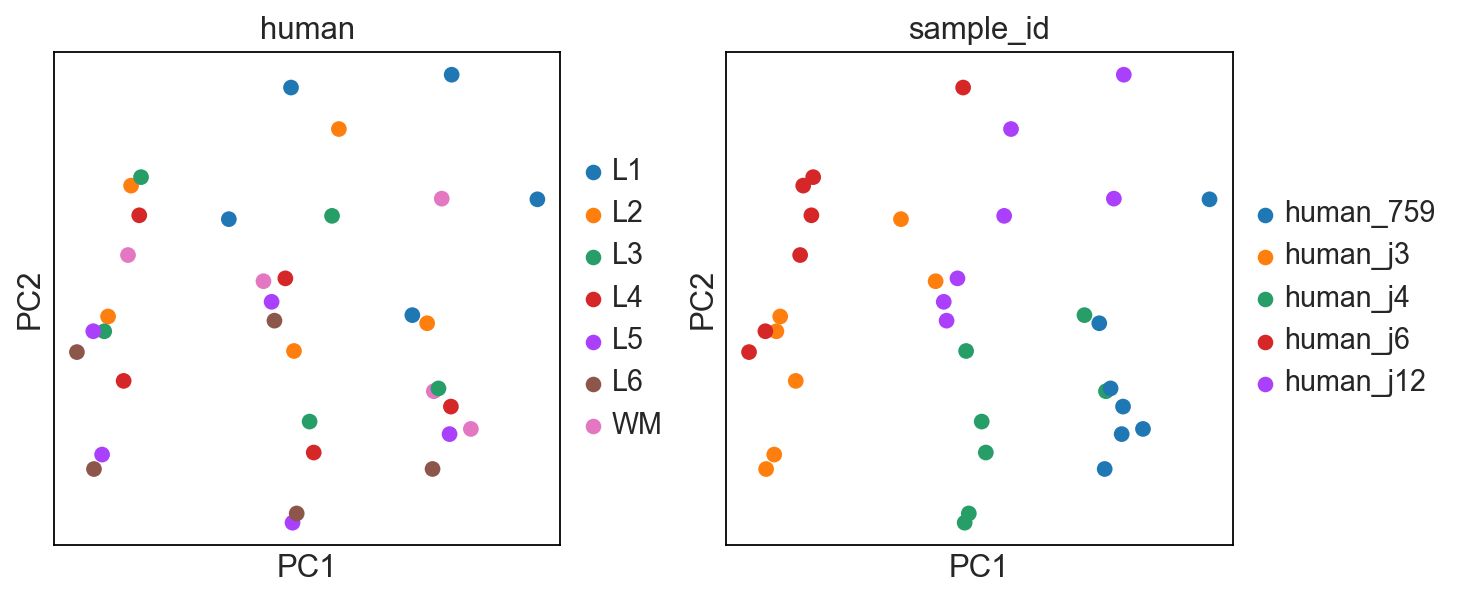

computing PCA
    with n_comps=30
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


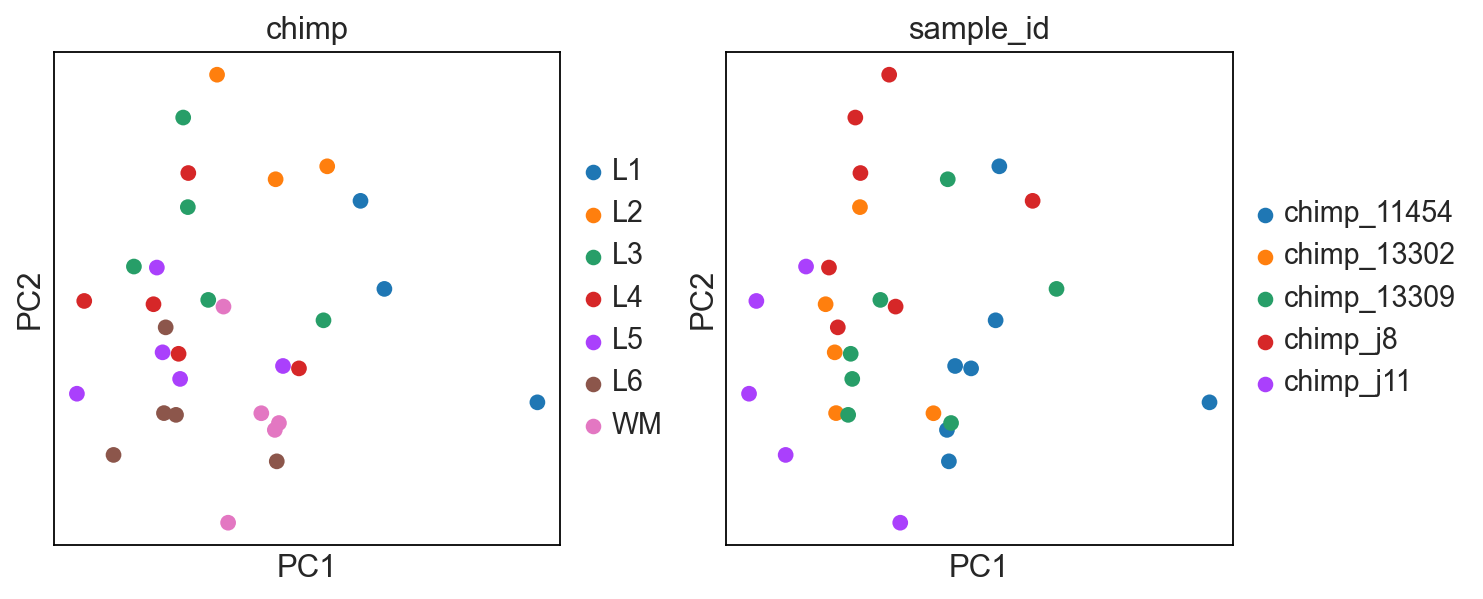

computing PCA
    with n_comps=27
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


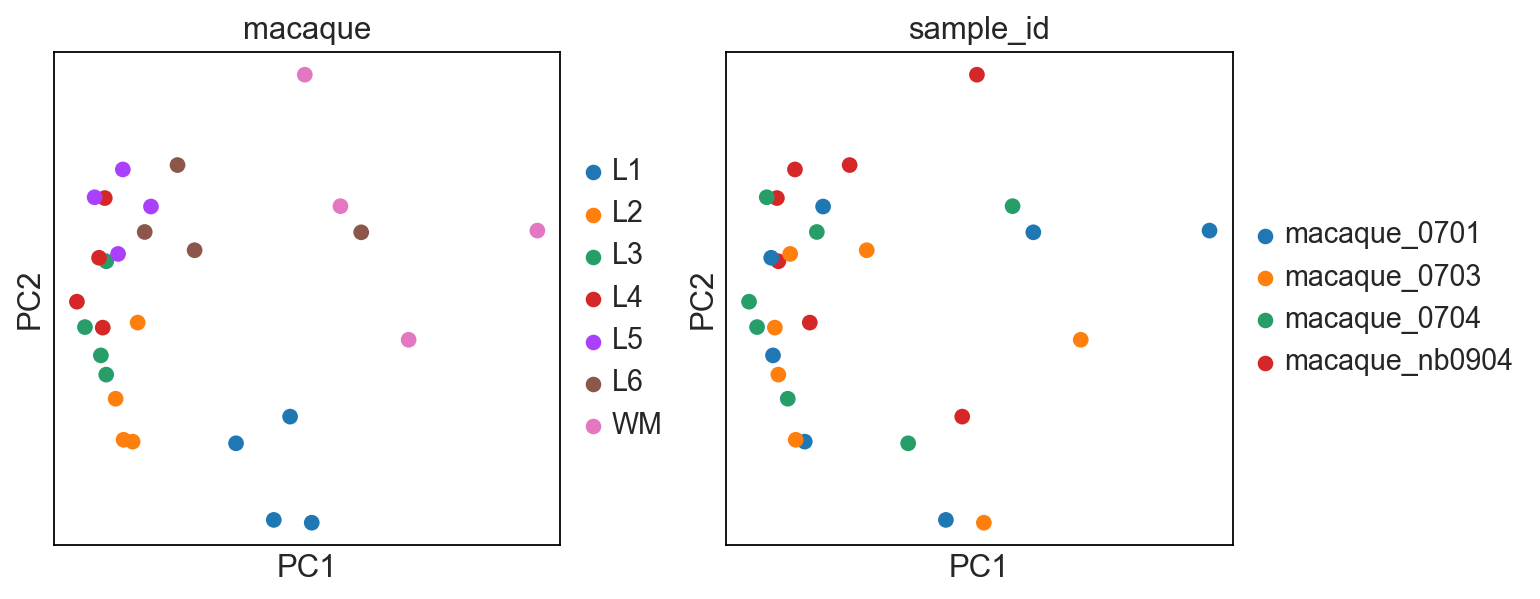

In [57]:
for cond in ['human', 'chimp', 'macaque']:
    adata_cond = adata_ssgsea[adata_ssgsea.obs.condition == cond, :].copy()
    sc.pp.pca(adata_cond, return_info=False)
    sc.pl.pca(adata_cond, color=['layer', 'sample_id'], size=200, ncols=2, title=cond)

d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


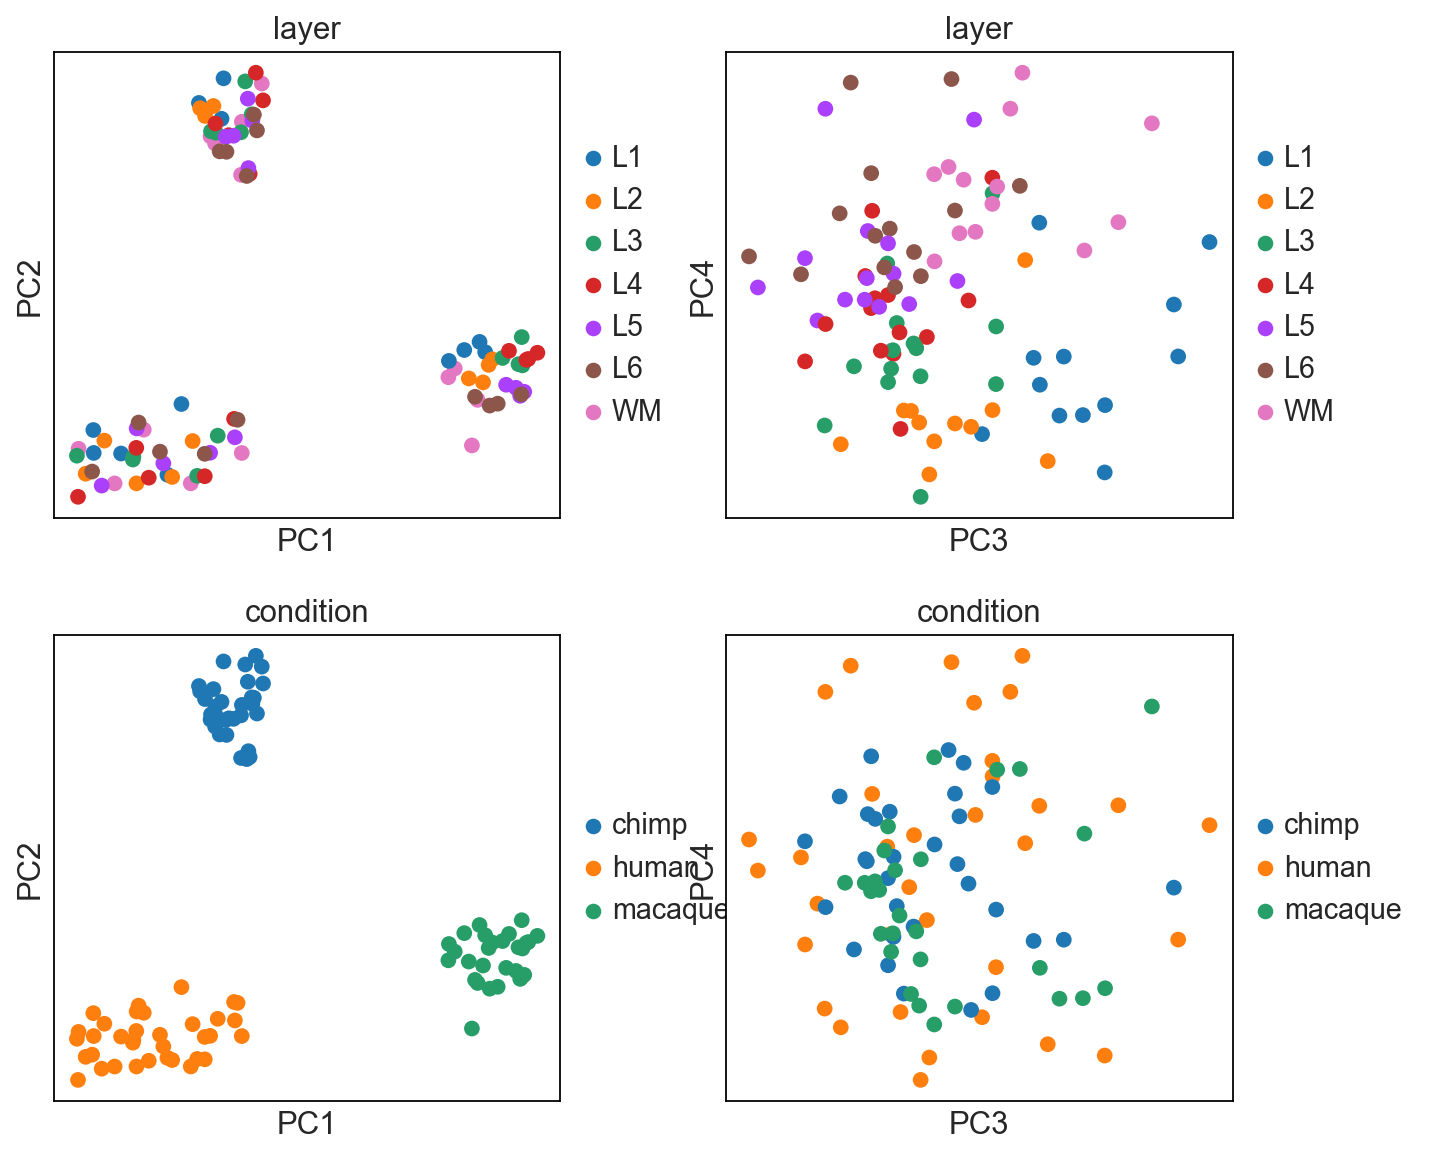

In [58]:
sc.pl.pca(adata_ssgsea, color=['layer', 'condition'], size=200, ncols=2, components = ['1,2','3,4'])

In [59]:
from scipy.stats import zscore
nes_zscore = nes.T
nes_zscore['sample_id'] = adata_ssgsea.obs.sample_id
nes_zscore = nes_zscore.groupby('sample_id', group_keys=False).apply(zscore)
nes_zscore.head()

Term,Human Astro L1 FGFR3 SERPINI2 up,Human Astro L1-6 FGFR3 AQP1 up,Human Astro L1-6 FGFR3 PLCG1 up,Human Endo L2-5 NOSTRIN SRGN up,Human Exc L2 LAMP5 KCNG3 up,Human Exc L2 LINC00507 ATP7B up,Human Exc L2 LINC00507 GLRA3 up,Human Exc L2-3 LINC00507 DSG3 up,Human Exc L2-3 RORB CCDC68 up,Human Exc L3 LAMP5 CARM1P1 up,...,Human Inh L5-6 SST PIK3CD up,Human Inh L5-6 VIP COL4A3 up,Human Inh L6 SST TH up,Human Micro L1-6 TYROBP CD74 up,Human OPC L1-6 PDGFRA COL20A1 up,Human Oligo L2-6 OPALIN FTH1P3 up,Human Oligo L2-6 OPALIN MAP6D1 up,Human Oligo L3-6 OPALIN ENPP6 up,Human Oligo L5-6 OPALIN LDLRAP1 up,Human VLMC L1-5 PDGFRA COLEC12 up
Name,,,,,,,,,,,,,,,,,,,,,
human_759_WM,-0.007107,-0.002184,-0.098601,-0.100788,-1.133984,-0.265465,-0.955459,-0.766400,-1.014860,-0.181169,...,-0.696090,0.729451,-0.964245,-0.951193,0.350995,1.261132,1.159474,0.530280,1.242407,0.412243
human_j12_WM,1.565442,1.566534,1.122210,1.828223,-1.494386,-2.003435,-0.542440,-1.300227,-1.236872,-0.145600,...,-0.588115,0.624724,-0.845289,1.335935,1.233986,1.774299,1.158911,1.448747,1.565939,1.272347
human_j3_WM,1.828446,2.036722,1.897115,1.783191,-1.968227,-0.703533,-1.018320,-1.426298,-1.342951,-0.487482,...,-1.587899,0.789347,-1.284209,0.502015,1.380858,1.968286,0.237974,2.138658,1.592395,2.170639
human_j4_WM,1.697969,1.583585,1.433649,2.085903,-1.320791,-1.859785,-0.908687,-1.156317,-1.847416,0.782632,...,-1.182123,0.290408,-0.698218,1.774153,1.584188,2.065106,1.931795,2.056650,2.169504,1.552539
human_j6_WM,0.937742,0.709381,0.637511,0.852203,-1.921608,-0.311807,-0.041786,-1.878861,-1.543066,-1.270434,...,0.467825,0.703634,1.085691,0.034087,1.444293,0.261469,0.088154,0.314879,0.862917,0.175455


In [60]:
cell_type = ['Astro', 'Exc', 'Inh', 'Oligo']
unique_celltypes = ['VLMC', 'OPC', 'Micro', 'Endo']

In [61]:
from sklearn.decomposition import PCA
X = nes_zscore.T.values
pca = PCA(n_components=2)
X_transf = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.30403292 0.15145198]
[53.78335956 37.95990378]


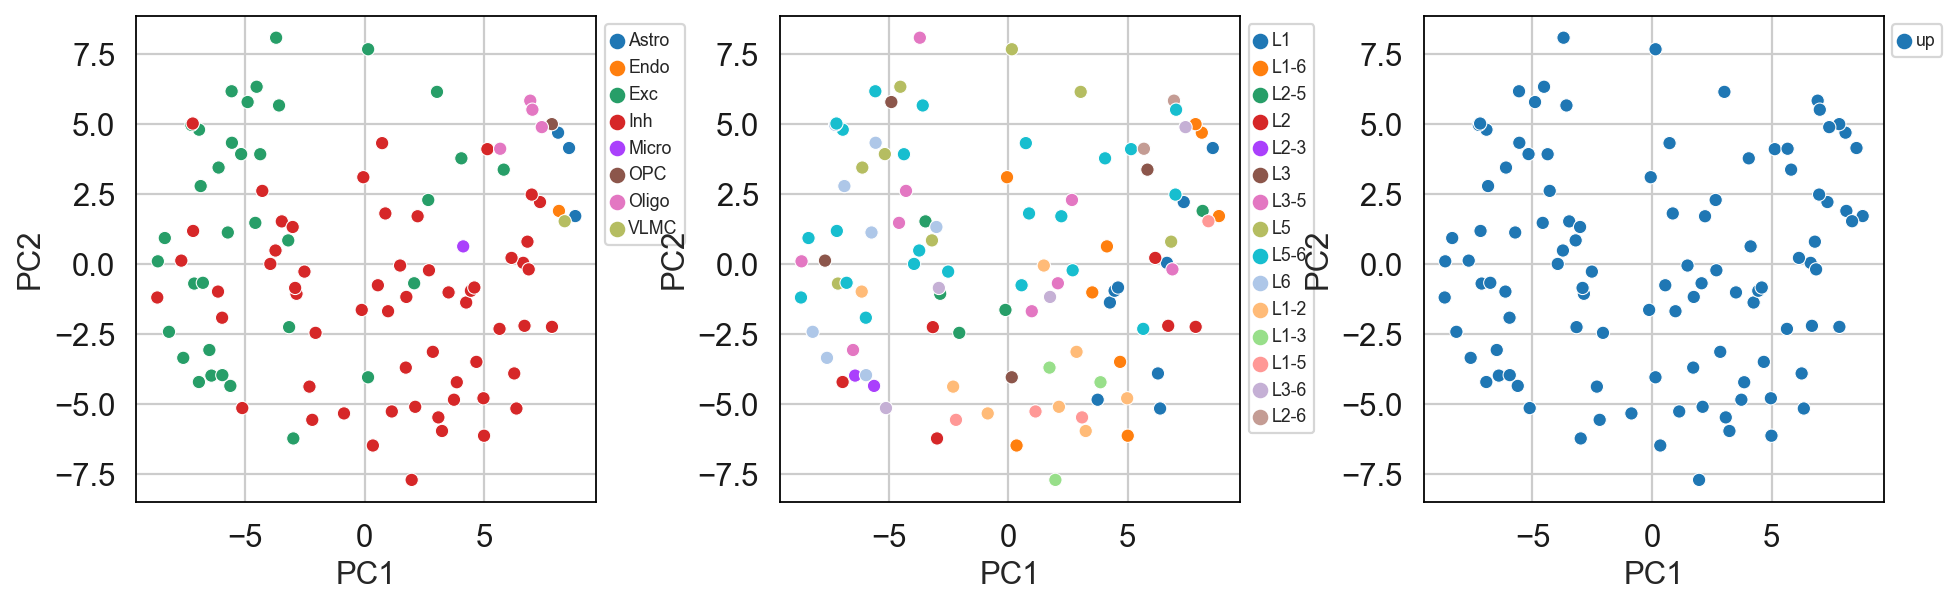

In [62]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4), gridspec_kw={'wspace': 0.4}, dpi=80)
pca_tr = pd.DataFrame(X_transf, index=nes_zscore.columns, columns=['PC1', 'PC2'])
pca_tr['major_ct'] = list(map(lambda x: x.split()[1], pca_tr.index))
pca_tr['layer'] = list(map(lambda x: x.split()[2], pca_tr.index))
pca_tr['direction'] = list(map(lambda x: x.split()[-1], pca_tr.index))
sns.scatterplot(pca_tr, x='PC1', y='PC2', hue='major_ct', ax=ax[0])
ax[0].legend(fontsize=2, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":8})
sns.scatterplot(pca_tr, x='PC1', y='PC2', hue='layer', ax=ax[1])
ax[1].legend(fontsize=2, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":8})
sns.scatterplot(pca_tr, x='PC1', y='PC2', hue='direction', ax=ax[2])
ax[2].legend(fontsize=2, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":8})

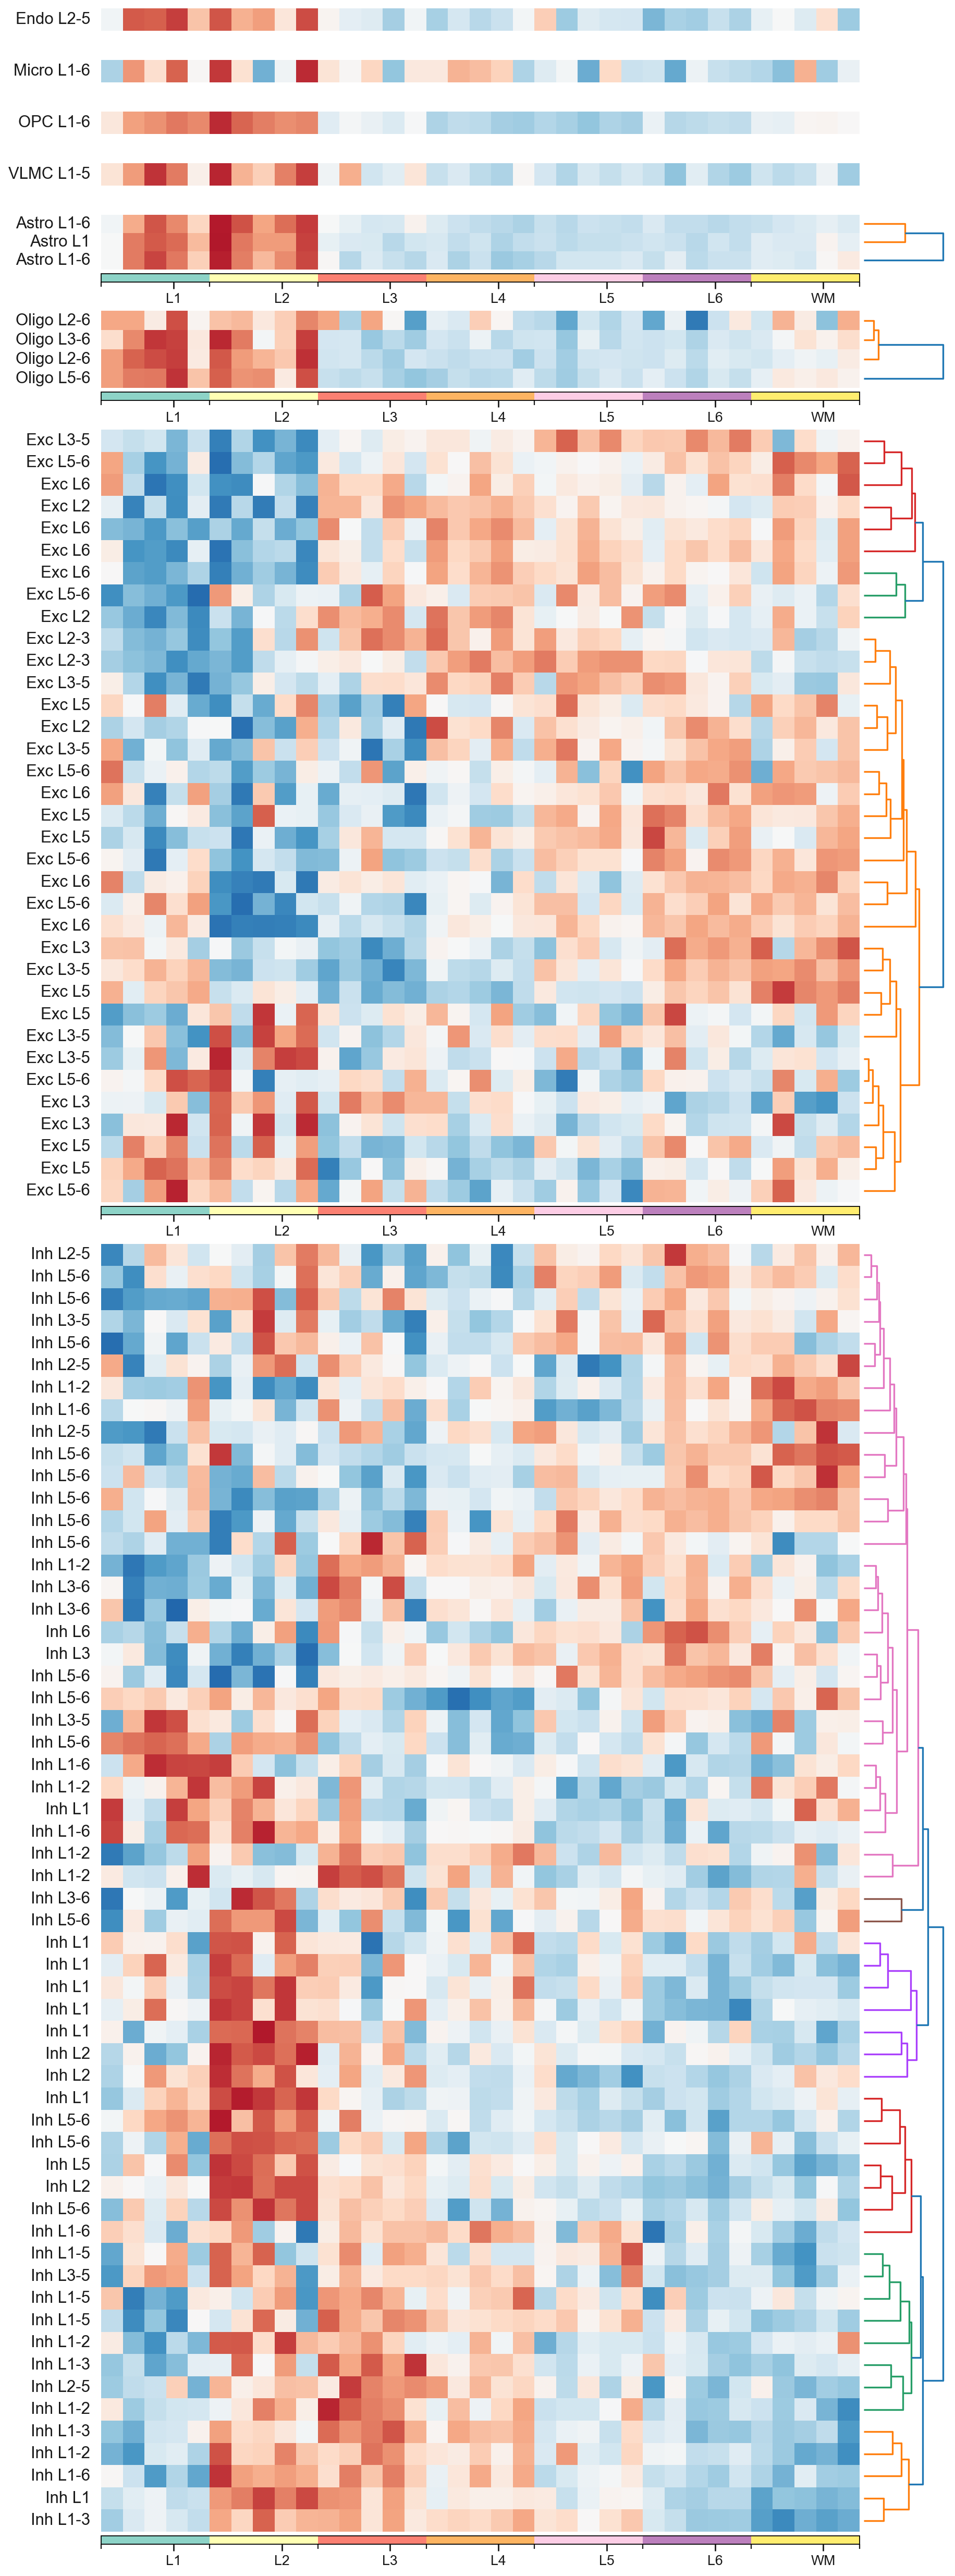

In [63]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from scipy.cluster.hierarchy import average, leaves_list, dendrogram
from scipy.spatial.distance import pdist

cell_type_counts = pca_tr.major_ct.value_counts(ascending=True).to_dict()
fig, axes = plt.subplots(len(cell_type_counts.values()), 1, figsize=(13, 40), height_ratios=cell_type_counts.values(), gridspec_kw={'hspace': 0.1}, dpi=80)

for ct, ax in zip(cell_type_counts.keys(), axes):
    celltype_ord = nes_zscore.columns.str.contains(ct)
    samp_ord = sample_order['human']
    df_sub = nes_zscore.loc[samp_ord, celltype_ord].T.copy()
    df_sub.index = df_sub.index.map(lambda x: ' '.join(x.split(' ')[1:3]))
    if ct in cell_type:
        linkage = average(pdist(df_sub.values, 'cosine'))
        index_ord = leaves_list(linkage)
        sns.heatmap(df_sub.iloc[index_ord, :], ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    else:
        sns.heatmap(df_sub, ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(False)
    ax.tick_params(axis="y", which="major", rotation=0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size=1, pad=0.05)
    cax.axis('off')

    if ct in cell_type:
        dn = dendrogram(linkage, ax=cax, orientation='right')

        # vertical
        cax = divider.append_axes('bottom', size=0.1, pad=0.05)

        cmap = plt.get_cmap('Set3')
        cond_size = adata_ssgsea[samp_ord].obs.layer.value_counts().loc[layers].values
        cond_pos = cond_size.cumsum()
        bounds = [0] + list(cond_pos)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        fig.colorbar(
            mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
            cax=cax,
            ticks=bounds,
            orientation='horizontal',
            spacing='proportional'
        )

        cax.xaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
        cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
        cax.set_xticklabels(cax.get_xticklabels(), rotation=0, fontsize=12)
plt.show()

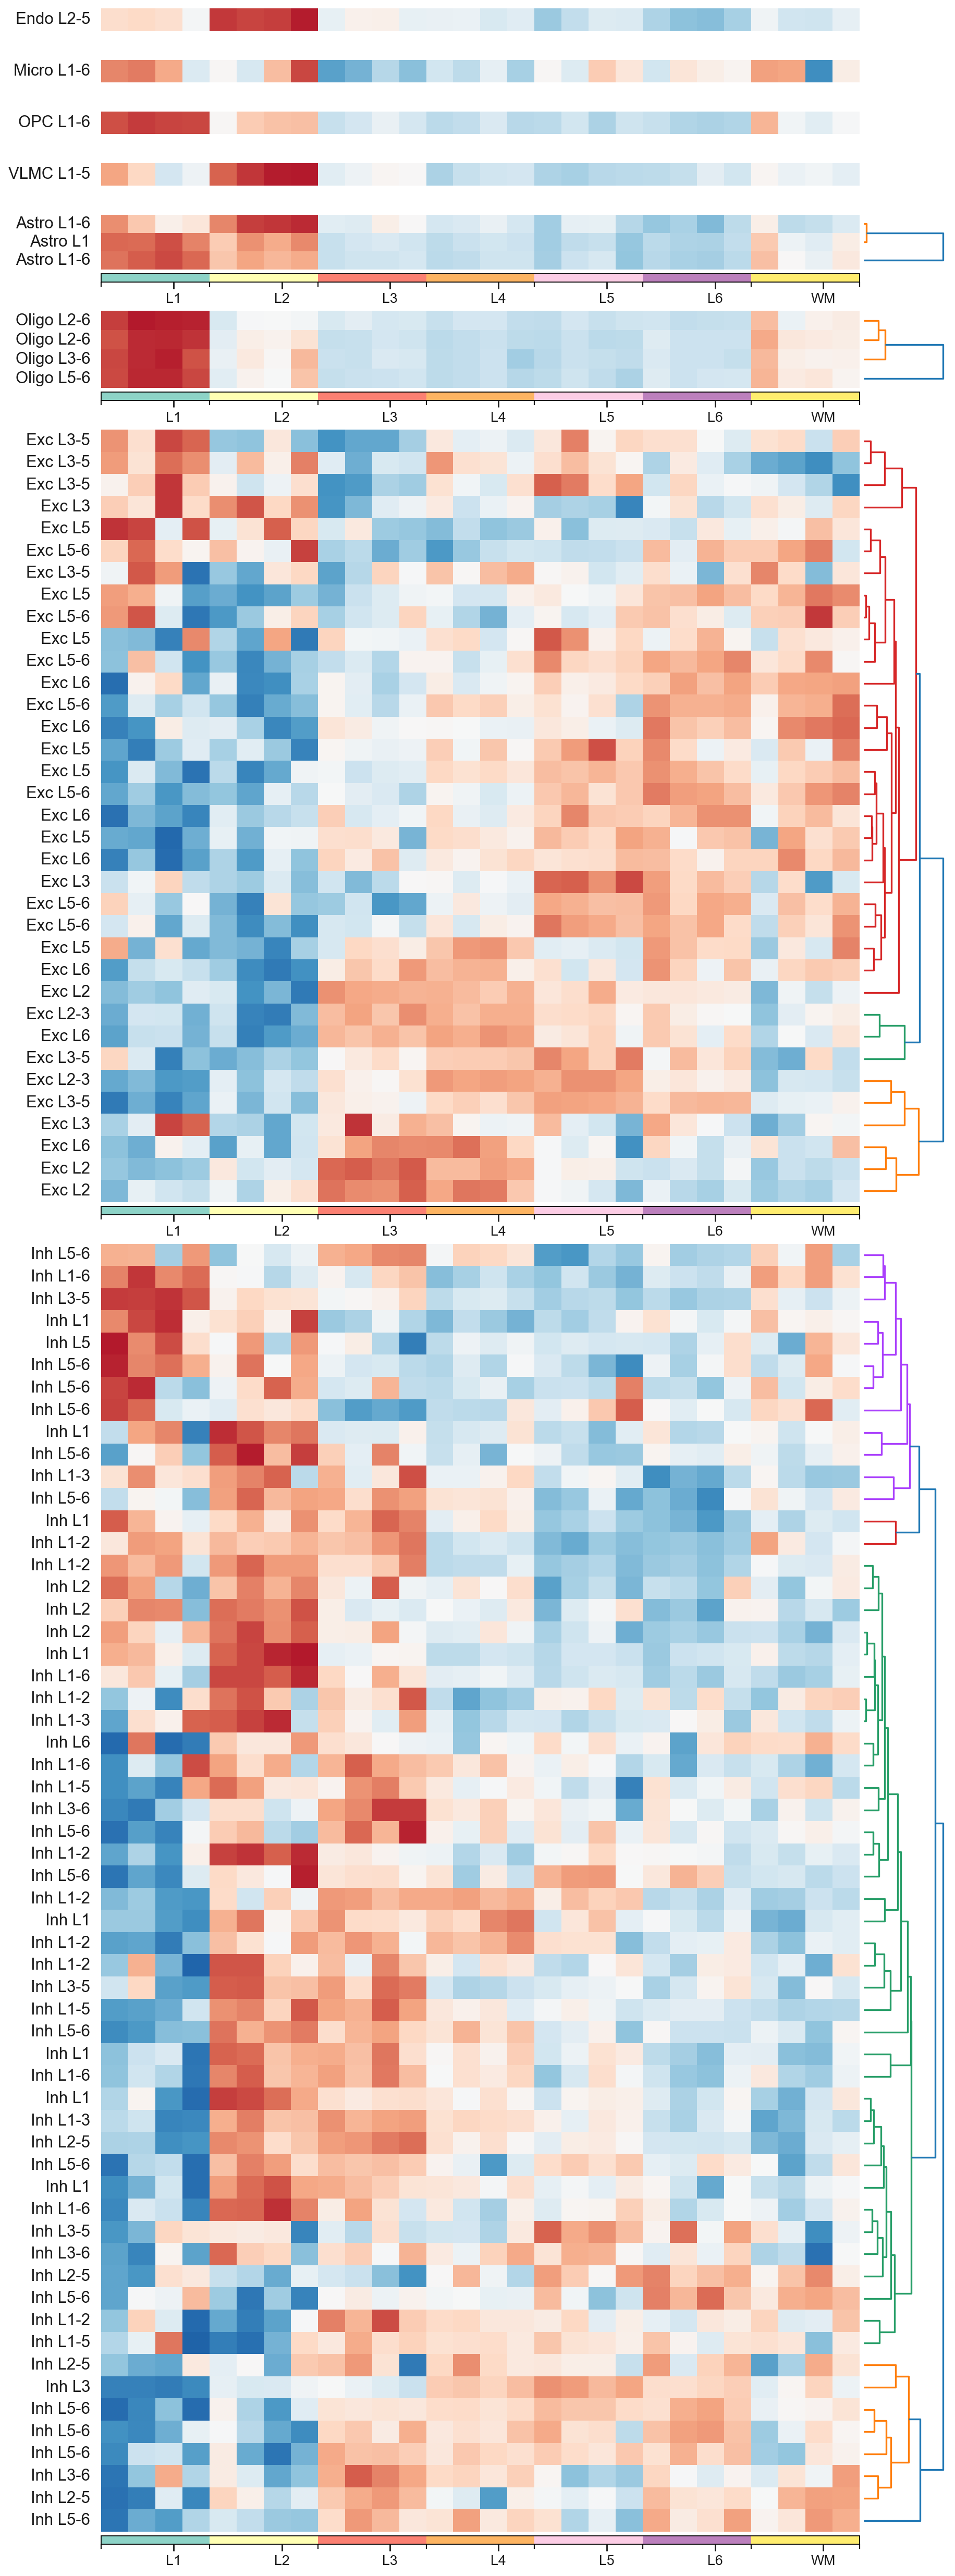

In [64]:
from scipy.cluster.hierarchy import average, leaves_list, dendrogram
from scipy.spatial.distance import pdist

cell_type_counts = pca_tr.major_ct.value_counts(ascending=True).to_dict()
fig, axes = plt.subplots(len(cell_type_counts.values()), 1, figsize=(13, 40), height_ratios=cell_type_counts.values(), gridspec_kw={'hspace': 0.1}, dpi=80)

for ct, ax in zip(cell_type_counts.keys(), axes):
    celltype_ord = nes_zscore.columns.str.contains(ct)
    samp_ord = sample_order['macaque']
    df_sub = nes_zscore.loc[samp_ord, celltype_ord].T.copy()
    df_sub.index = df_sub.index.map(lambda x: ' '.join(x.split(' ')[1:3]))
    if ct in cell_type:
        linkage = average(pdist(df_sub.values, 'cosine'))
        index_ord = leaves_list(linkage)
        sns.heatmap(df_sub.iloc[index_ord, :], ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    else:
        sns.heatmap(df_sub, ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(False)
    ax.tick_params(axis="y", which="major", rotation=0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size=1, pad=0.05)
    cax.axis('off')

    if ct in cell_type:
        dn = dendrogram(linkage, ax=cax, orientation='right')

        # vertical
        cax = divider.append_axes('bottom', size=0.1, pad=0.05)

        cmap = plt.get_cmap('Set3')
        cond_size = adata_ssgsea[samp_ord].obs.layer.value_counts().loc[layers].values
        cond_pos = cond_size.cumsum()
        bounds = [0] + list(cond_pos)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        fig.colorbar(
            mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
            cax=cax,
            ticks=bounds,
            orientation='horizontal',
            spacing='proportional'
        )

        cax.xaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
        cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
        cax.set_xticklabels(cax.get_xticklabels(), rotation=0, fontsize=12)
plt.show()

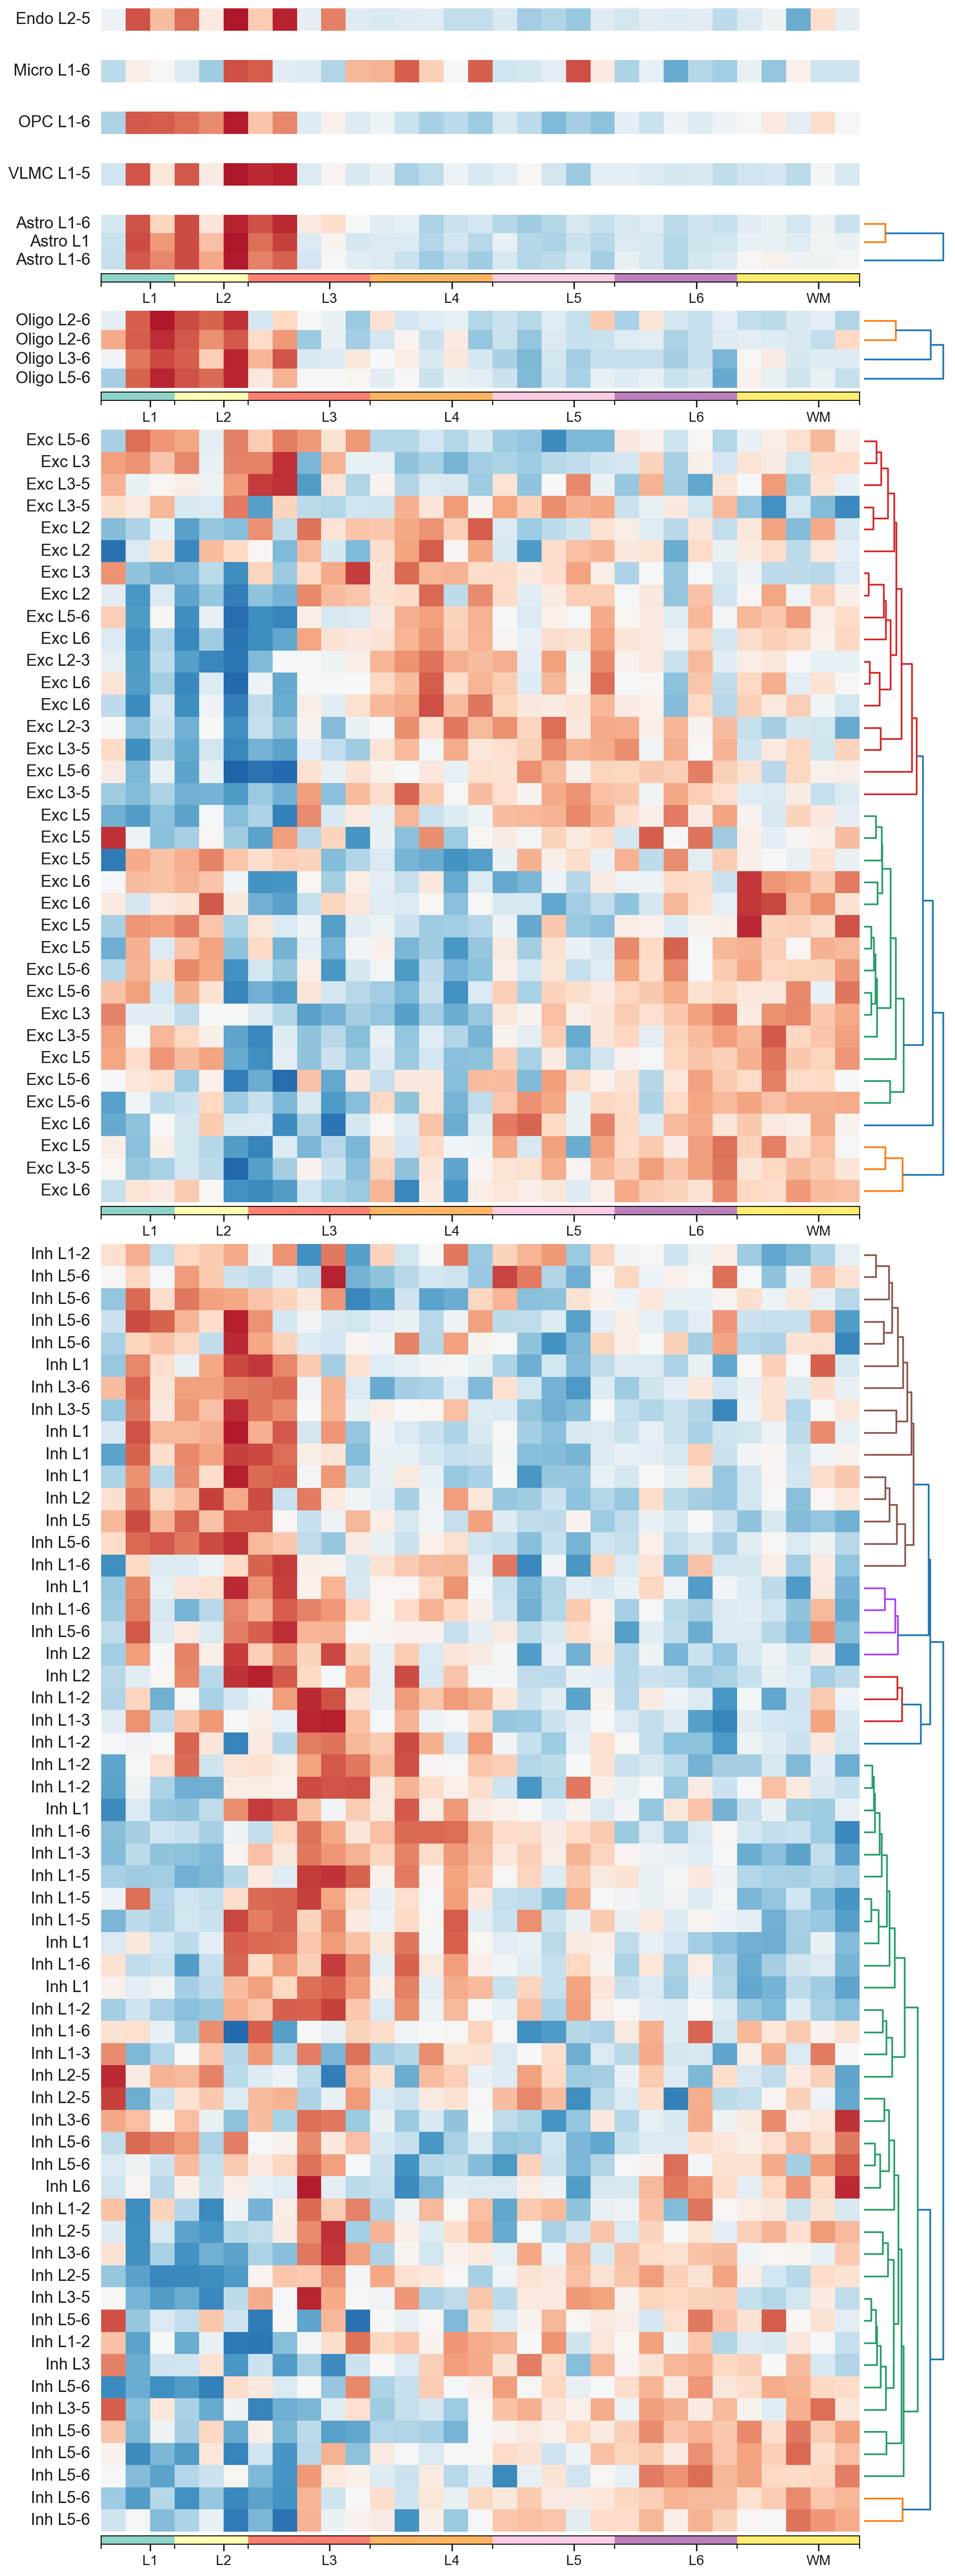

In [65]:
from scipy.cluster.hierarchy import average, leaves_list, dendrogram
from scipy.spatial.distance import pdist

cell_type_counts = pca_tr.major_ct.value_counts(ascending=True).to_dict()
fig, axes = plt.subplots(len(cell_type_counts.values()), 1, figsize=(13, 40), height_ratios=cell_type_counts.values(), gridspec_kw={'hspace': 0.1}, dpi=80)

for ct, ax in zip(cell_type_counts.keys(), axes):
    celltype_ord = nes_zscore.columns.str.contains(ct)
    samp_ord = sample_order['chimp']
    df_sub = nes_zscore.loc[samp_ord, celltype_ord].T.copy()
    df_sub.index = df_sub.index.map(lambda x: ' '.join(x.split(' ')[1:3]))
    if ct in cell_type:
        linkage = average(pdist(df_sub.values, 'cosine'))
        index_ord = leaves_list(linkage)
        sns.heatmap(df_sub.iloc[index_ord, :], ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    else:
        sns.heatmap(df_sub, ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.grid(False)
    ax.tick_params(axis="y", which="major", rotation=0)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size=1, pad=0.05)
    cax.axis('off')

    if ct in cell_type:
        dn = dendrogram(linkage, ax=cax, orientation='right')

        # vertical
        cax = divider.append_axes('bottom', size=0.1, pad=0.05)

        cmap = plt.get_cmap('Set3')
        cond_size = adata_ssgsea[samp_ord].obs.layer.value_counts().loc[layers].values
        cond_pos = cond_size.cumsum()
        bounds = [0] + list(cond_pos)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        fig.colorbar(
            mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
            cax=cax,
            ticks=bounds,
            orientation='horizontal',
            spacing='proportional'
        )

        cax.xaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
        cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
        cax.set_xticklabels(cax.get_xticklabels(), rotation=0, fontsize=12)
plt.show()

In [67]:
index_ord

array([32, 49, 47, 35, 53, 33,  9, 25, 31, 55, 46, 52, 54, 51, 13, 39, 40,
       57, 34, 50, 56, 36, 43, 23, 10,  3, 22,  8, 11, 38, 44,  2,  5,  0,
        1,  6, 29, 28,  4, 42, 45, 41, 27, 48, 24, 19, 37, 20, 21, 15, 18,
       30, 14, 16, 12, 26,  7, 17], dtype=int32)

In [68]:
df_sub

Name,chimp_11454_WM,chimp_13302_WM,chimp_13309_WM,chimp_j11_WM,chimp_j8_WM,chimp_11454_L1,chimp_13309_L1,chimp_j8_L1,chimp_11454_L2,chimp_13309_L2,...,chimp_11454_L5,chimp_13302_L5,chimp_13309_L5,chimp_j11_L5,chimp_j8_L5,chimp_11454_L6,chimp_13302_L6,chimp_13309_L6,chimp_j11_L6,chimp_j8_L6
Term,,,,,,,,,,,,,,,,,,,,,
Astro L1,-0.664052,1.959103,1.305324,1.959952,0.905624,2.427679,1.654313,2.041361,-0.426049,0.094891,...,-0.425168,-0.470278,-0.857007,-0.619623,-0.568476,-0.239528,-0.221254,-0.363226,-0.111048,-0.191640
Astro L1-6,-0.711116,1.873766,1.465025,1.962273,1.163936,2.388760,1.493023,1.770280,-0.552420,-0.035266,...,-0.228475,-0.470130,-0.873106,-0.518646,-0.405113,0.027381,0.159007,-0.157636,-0.153189,-0.085849
Astro L1-6,-0.538645,1.899143,0.668965,1.967933,0.381238,2.317103,1.922588,2.260606,0.277515,0.552224,...,-0.511642,-0.369244,-0.795857,-0.629319,-0.685754,-0.329651,-0.201693,-0.557505,-0.163994,-0.672062


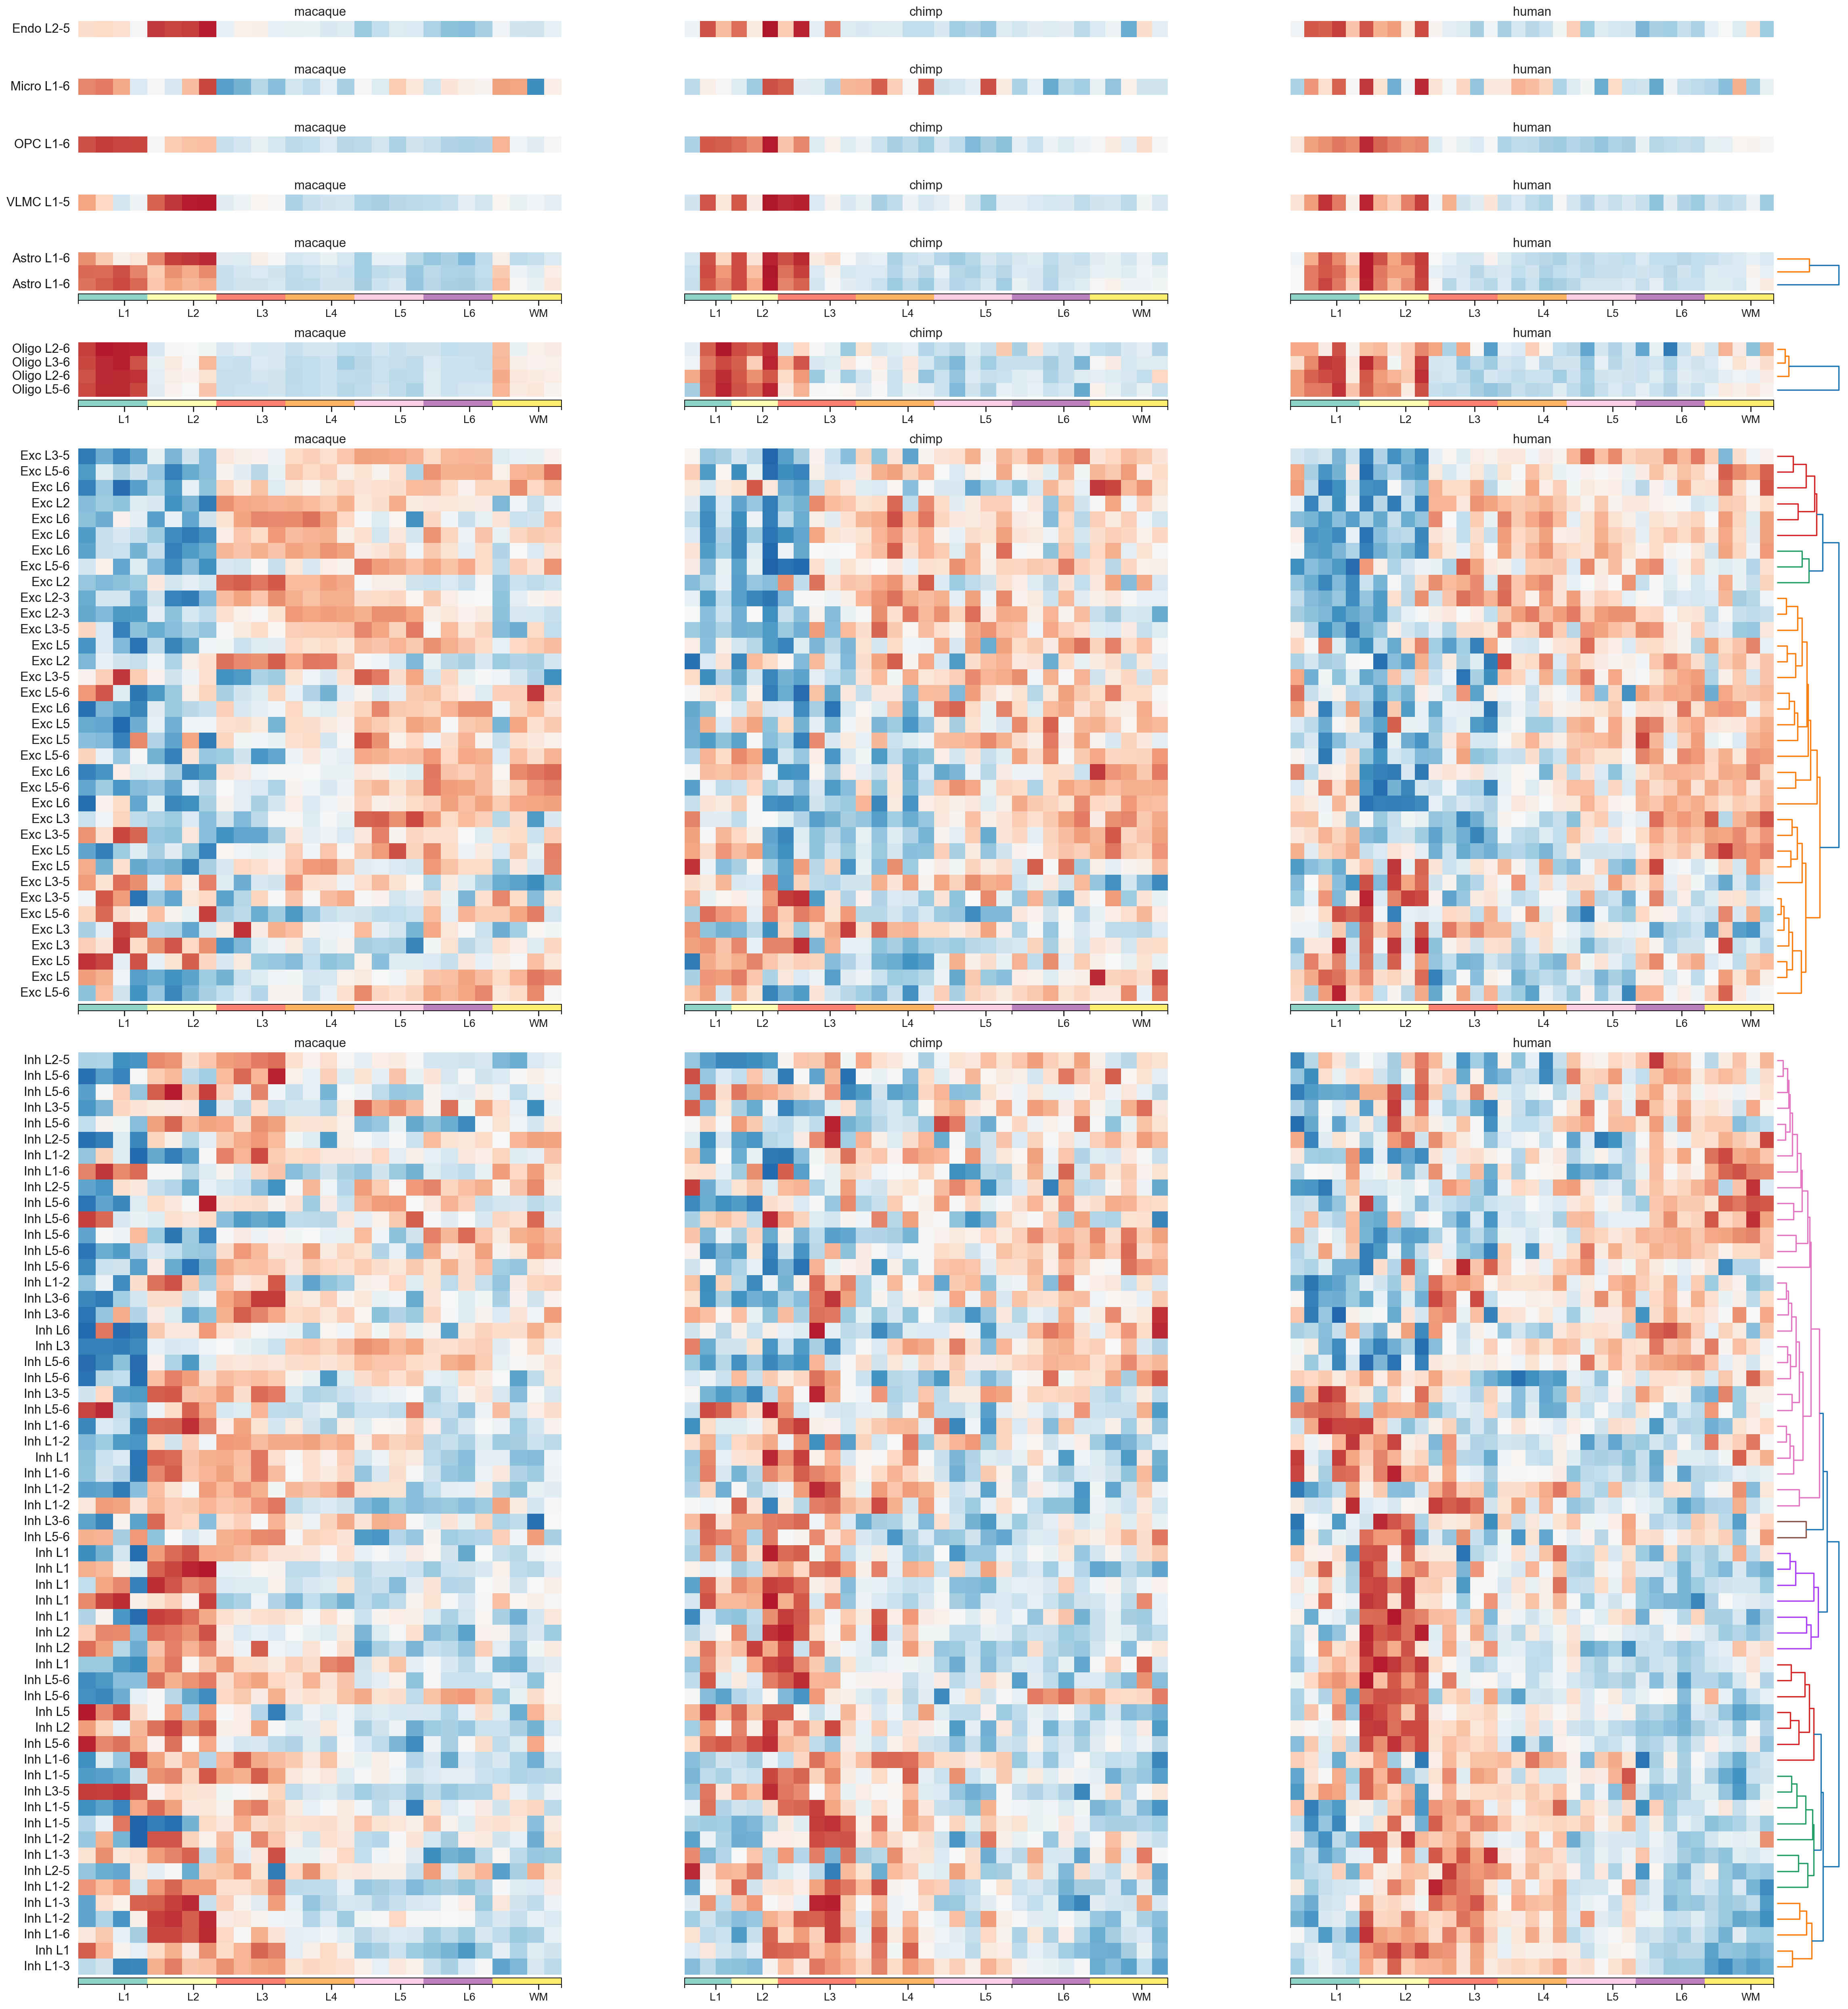

In [72]:
from scipy.cluster.hierarchy import average, leaves_list, dendrogram
from scipy.spatial.distance import pdist

cell_type_counts = pca_tr.major_ct.value_counts(ascending=True).to_dict()
fig, axes = plt.subplots(len(cell_type_counts.values()), 3, figsize=(35, 40), height_ratios=cell_type_counts.values(), gridspec_kw={'hspace': 0.2, 'wspace': 0.1}, dpi=80)


for j, ct in enumerate(cell_type_counts.keys()):
    for sp, ax in zip(['human', 'chimp', 'macaque'], axes[j, :][::-1]):
        celltype_ord = nes_zscore.columns.str.contains(ct)
        samp_ord = sample_order[sp]
        df_sub = nes_zscore.loc[samp_ord, celltype_ord].T.copy()
        df_sub.index = df_sub.index.map(lambda x: ' '.join(x.split(' ')[1:3]))
        if ct in cell_type:
            if sp == 'human':
                linkage = average(pdist(df_sub.values, 'cosine'))
                index_ord = leaves_list(linkage)
            sns.heatmap(df_sub.iloc[index_ord, :], ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
        else:
            sns.heatmap(df_sub, ax=ax, cmap="RdBu_r", vmax=3, vmin=-3, center=0, cbar=False)
        ax.set_title(sp)
        if sp != 'macaque':
            ax.set_yticks([])
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.grid(False)
        ax.tick_params(axis="y", which="major", rotation=0)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size=1, pad=0.05)
        cax.axis('off')

        if ct in cell_type:
            if sp == 'human':
                dn = dendrogram(linkage, ax=cax, orientation='right')

            # vertical
            cax = divider.append_axes('bottom', size=0.1, pad=0.05)

            cmap = plt.get_cmap('Set3')
            cond_size = adata_ssgsea[samp_ord].obs.layer.value_counts().loc[layers].values
            cond_pos = cond_size.cumsum()
            bounds = [0] + list(cond_pos)
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

            fig.colorbar(
                mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
                cax=cax,
                ticks=bounds,
                orientation='horizontal',
                spacing='proportional'
            )

            cax.xaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
            cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
            cax.set_xticklabels(cax.get_xticklabels(), rotation=0, fontsize=12)
plt.show()

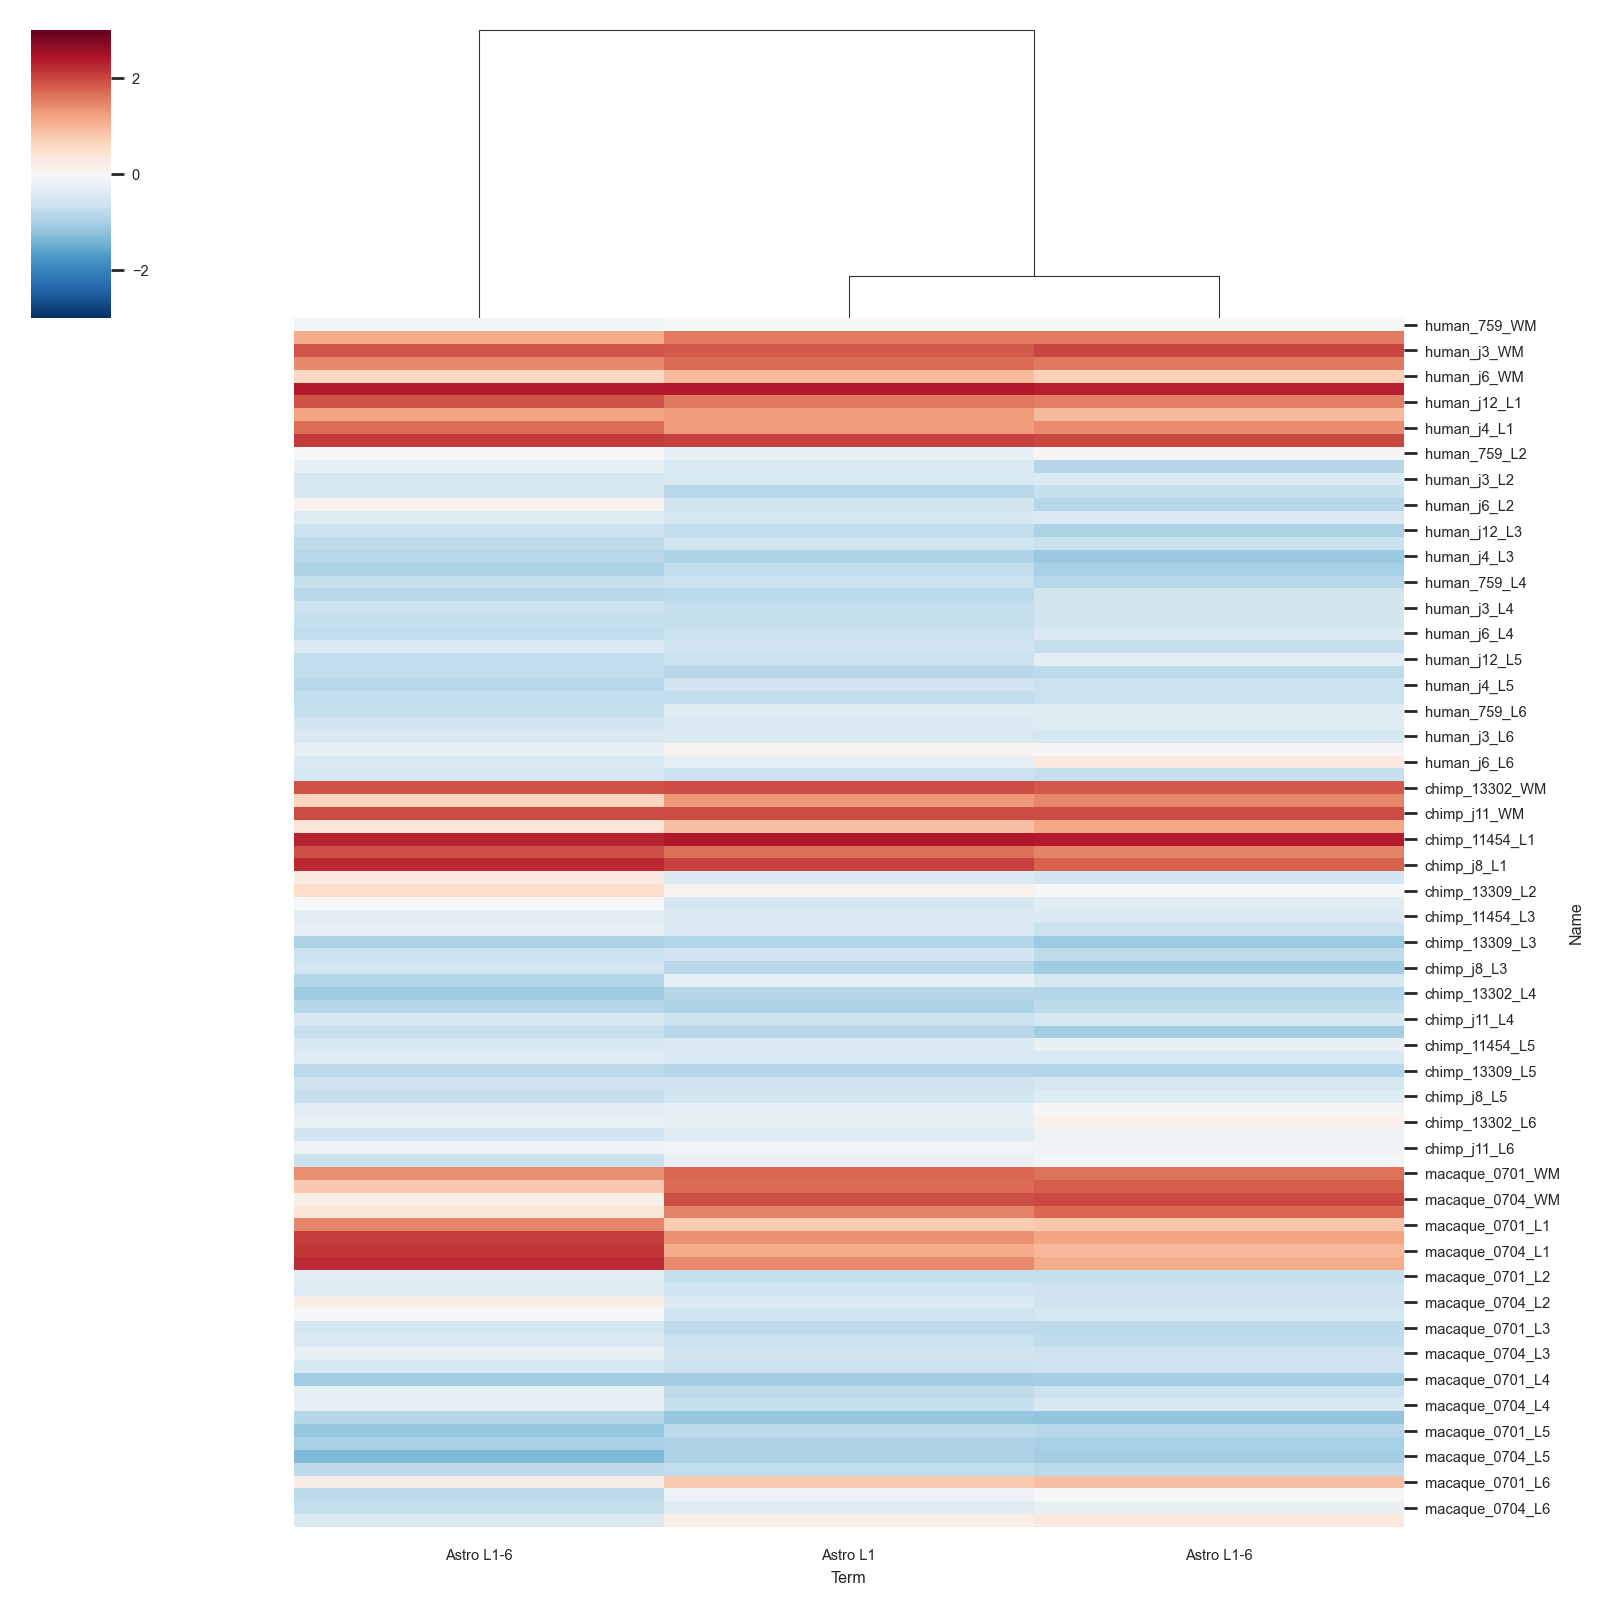

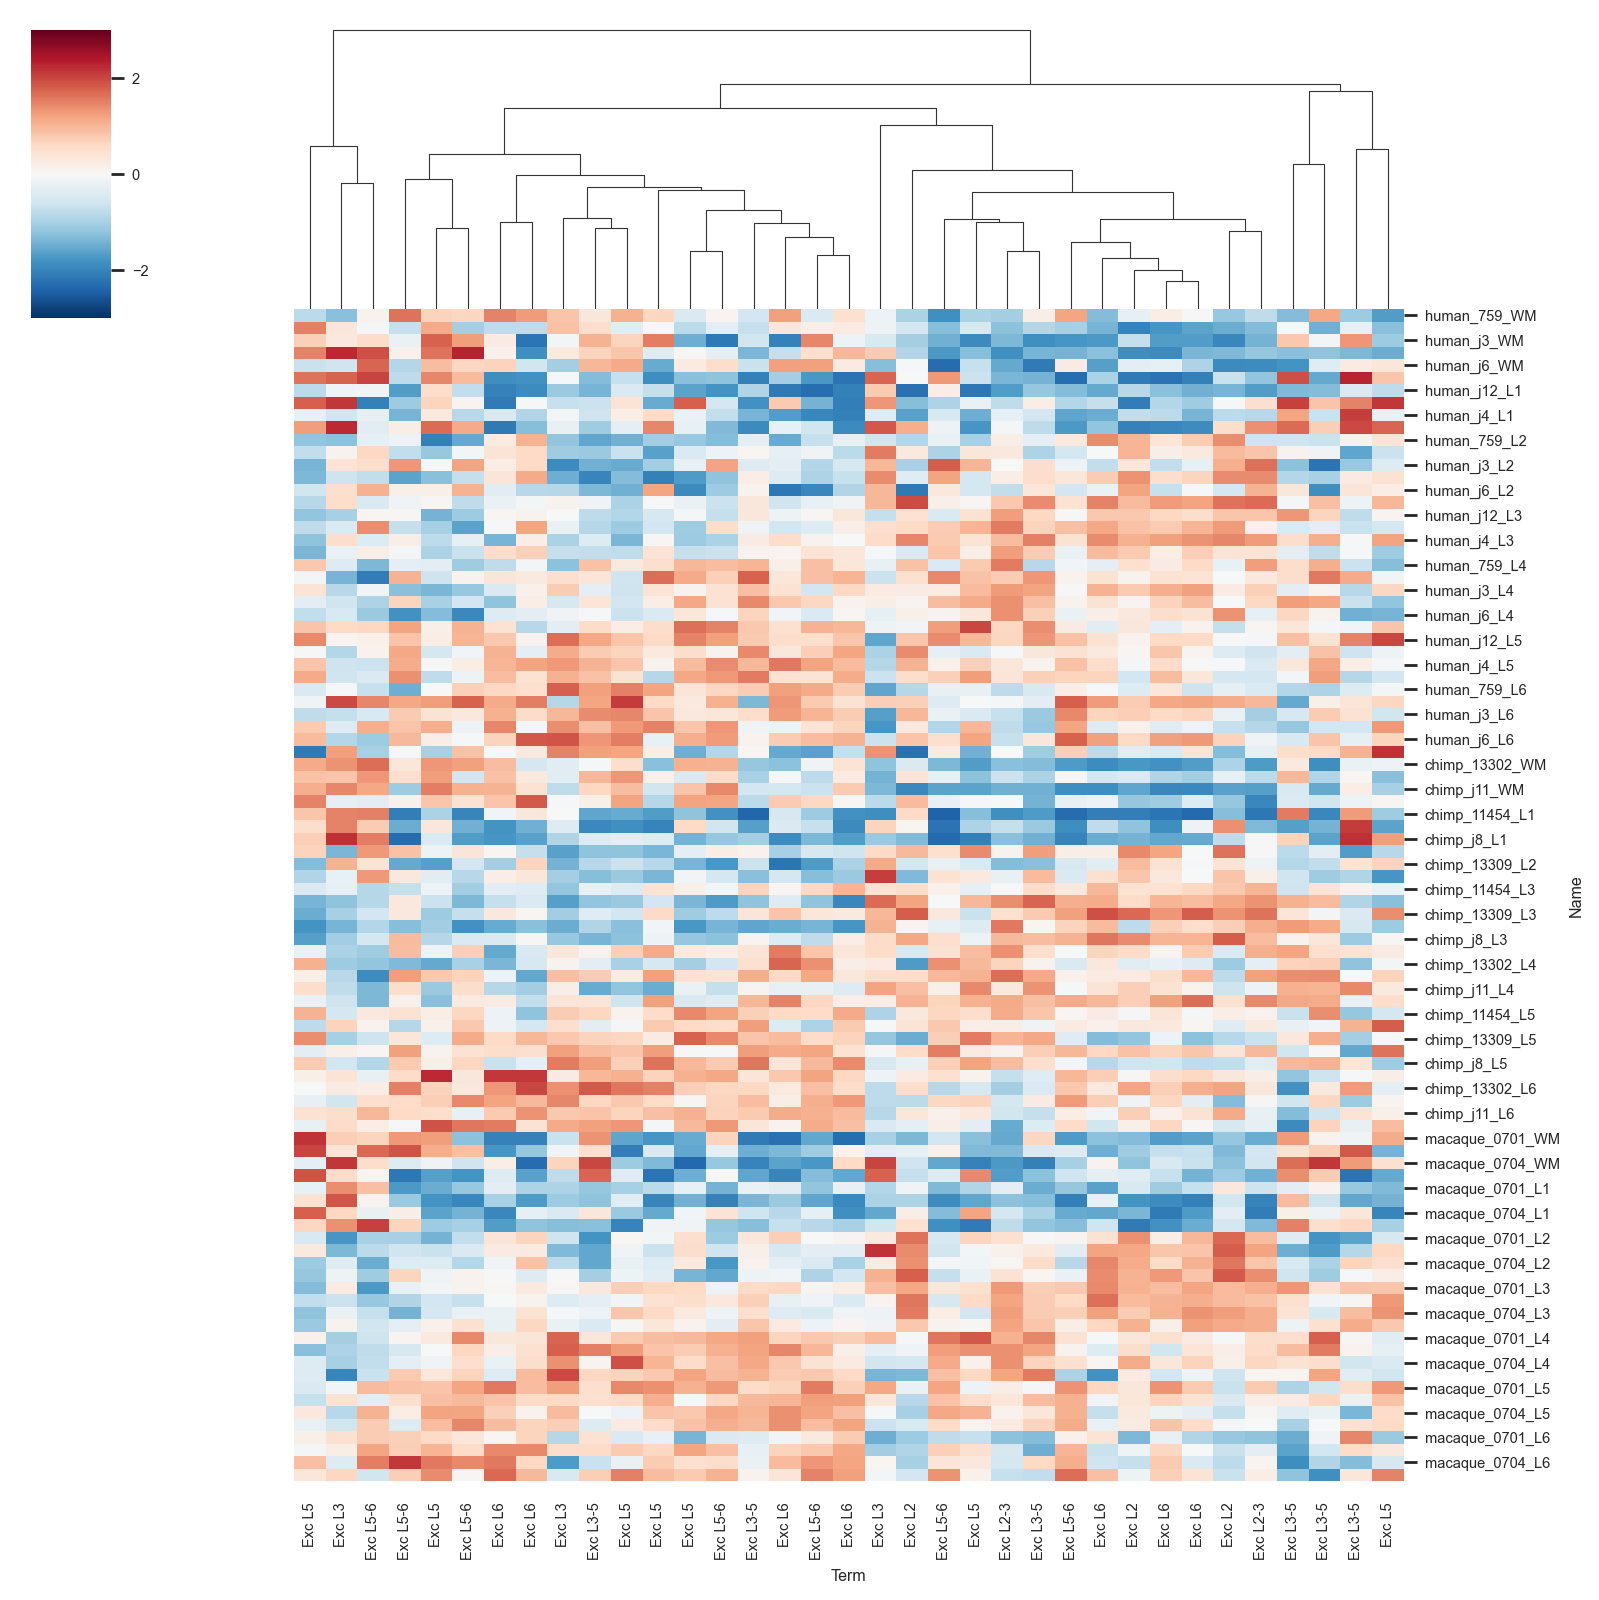

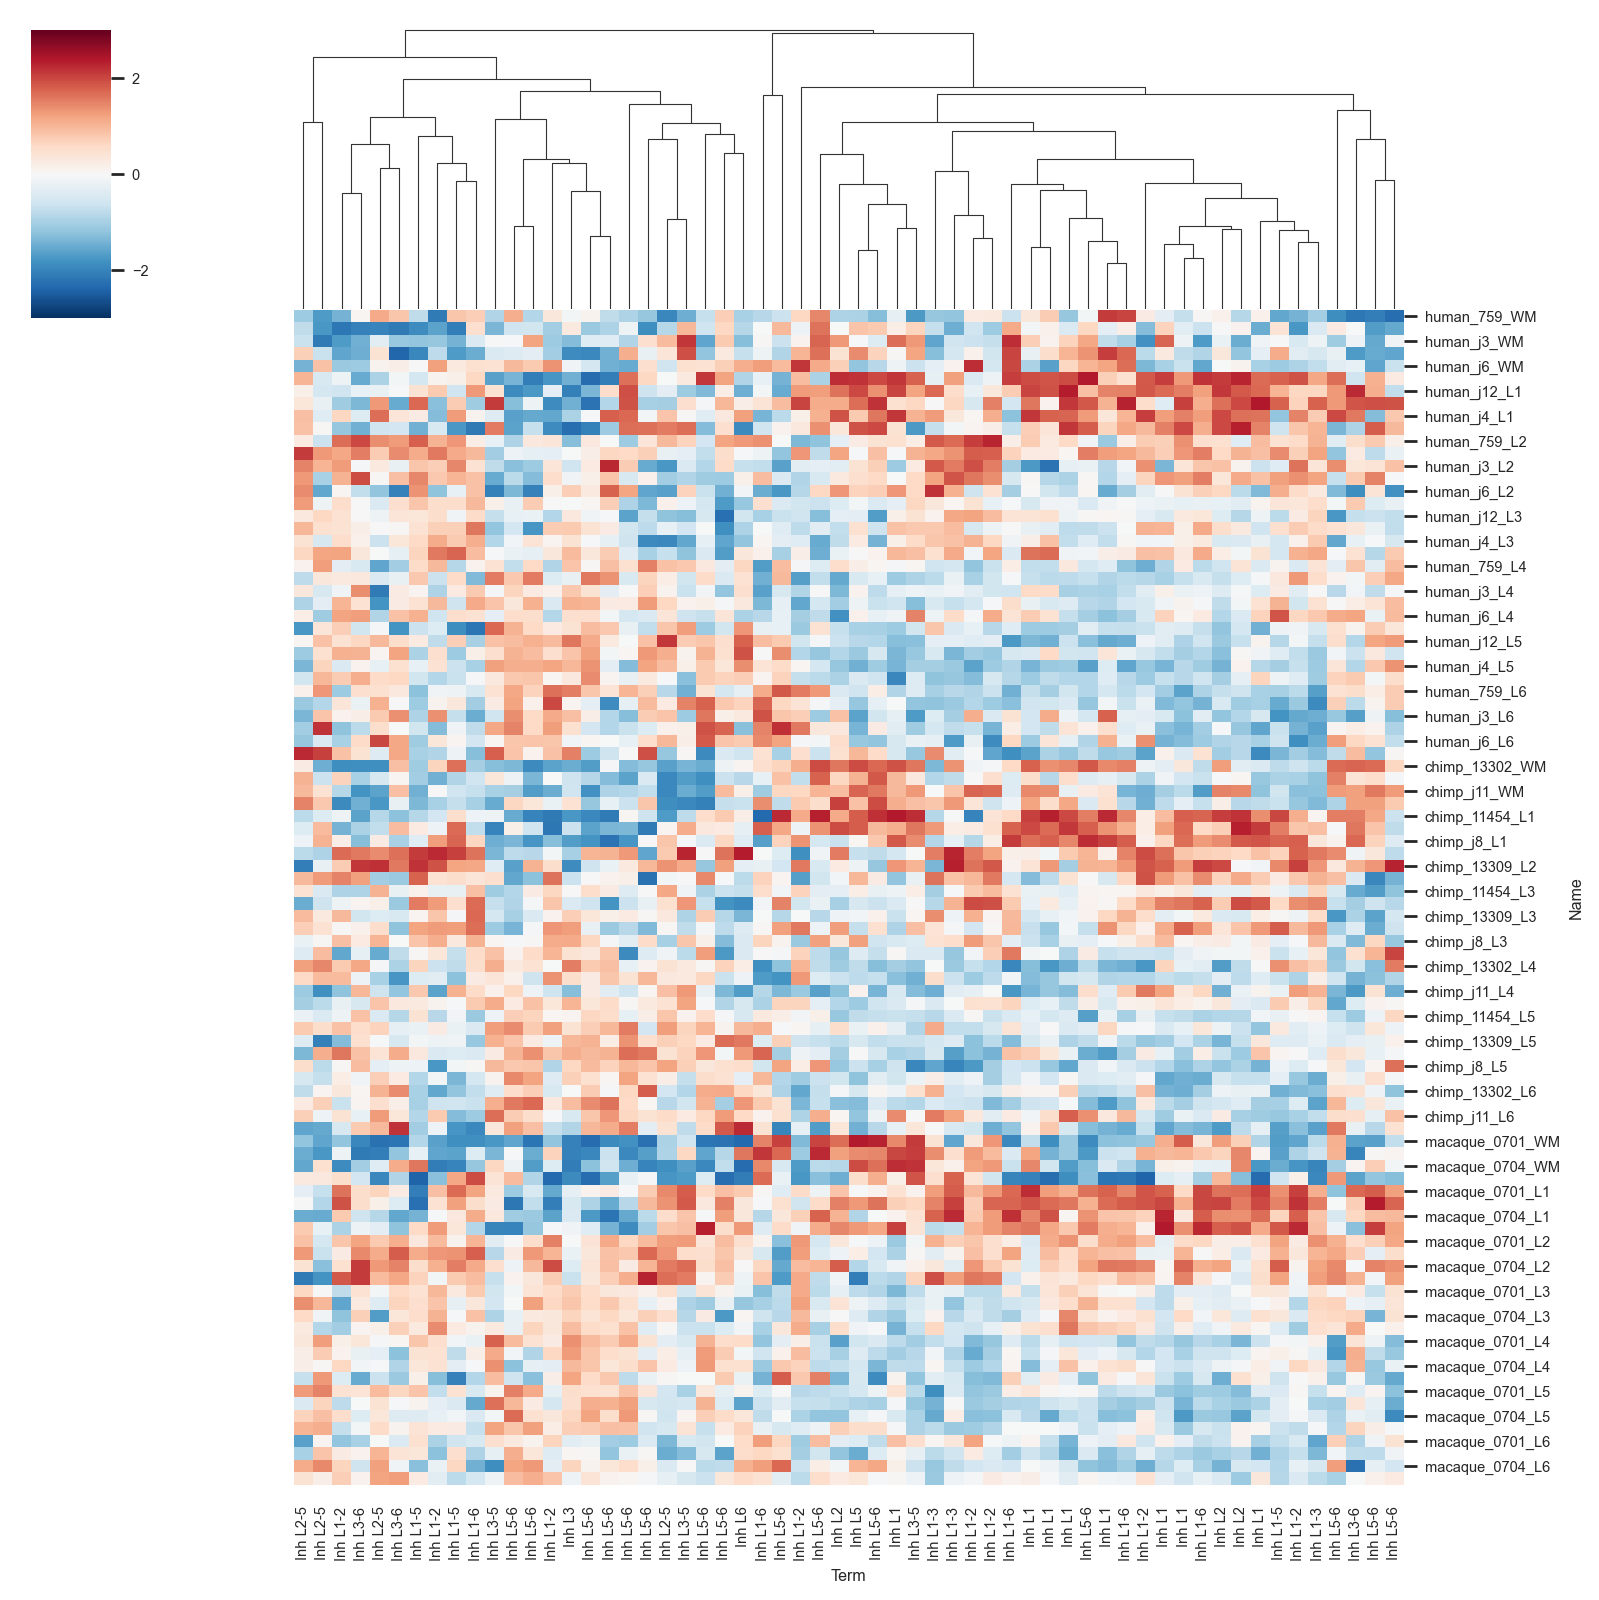

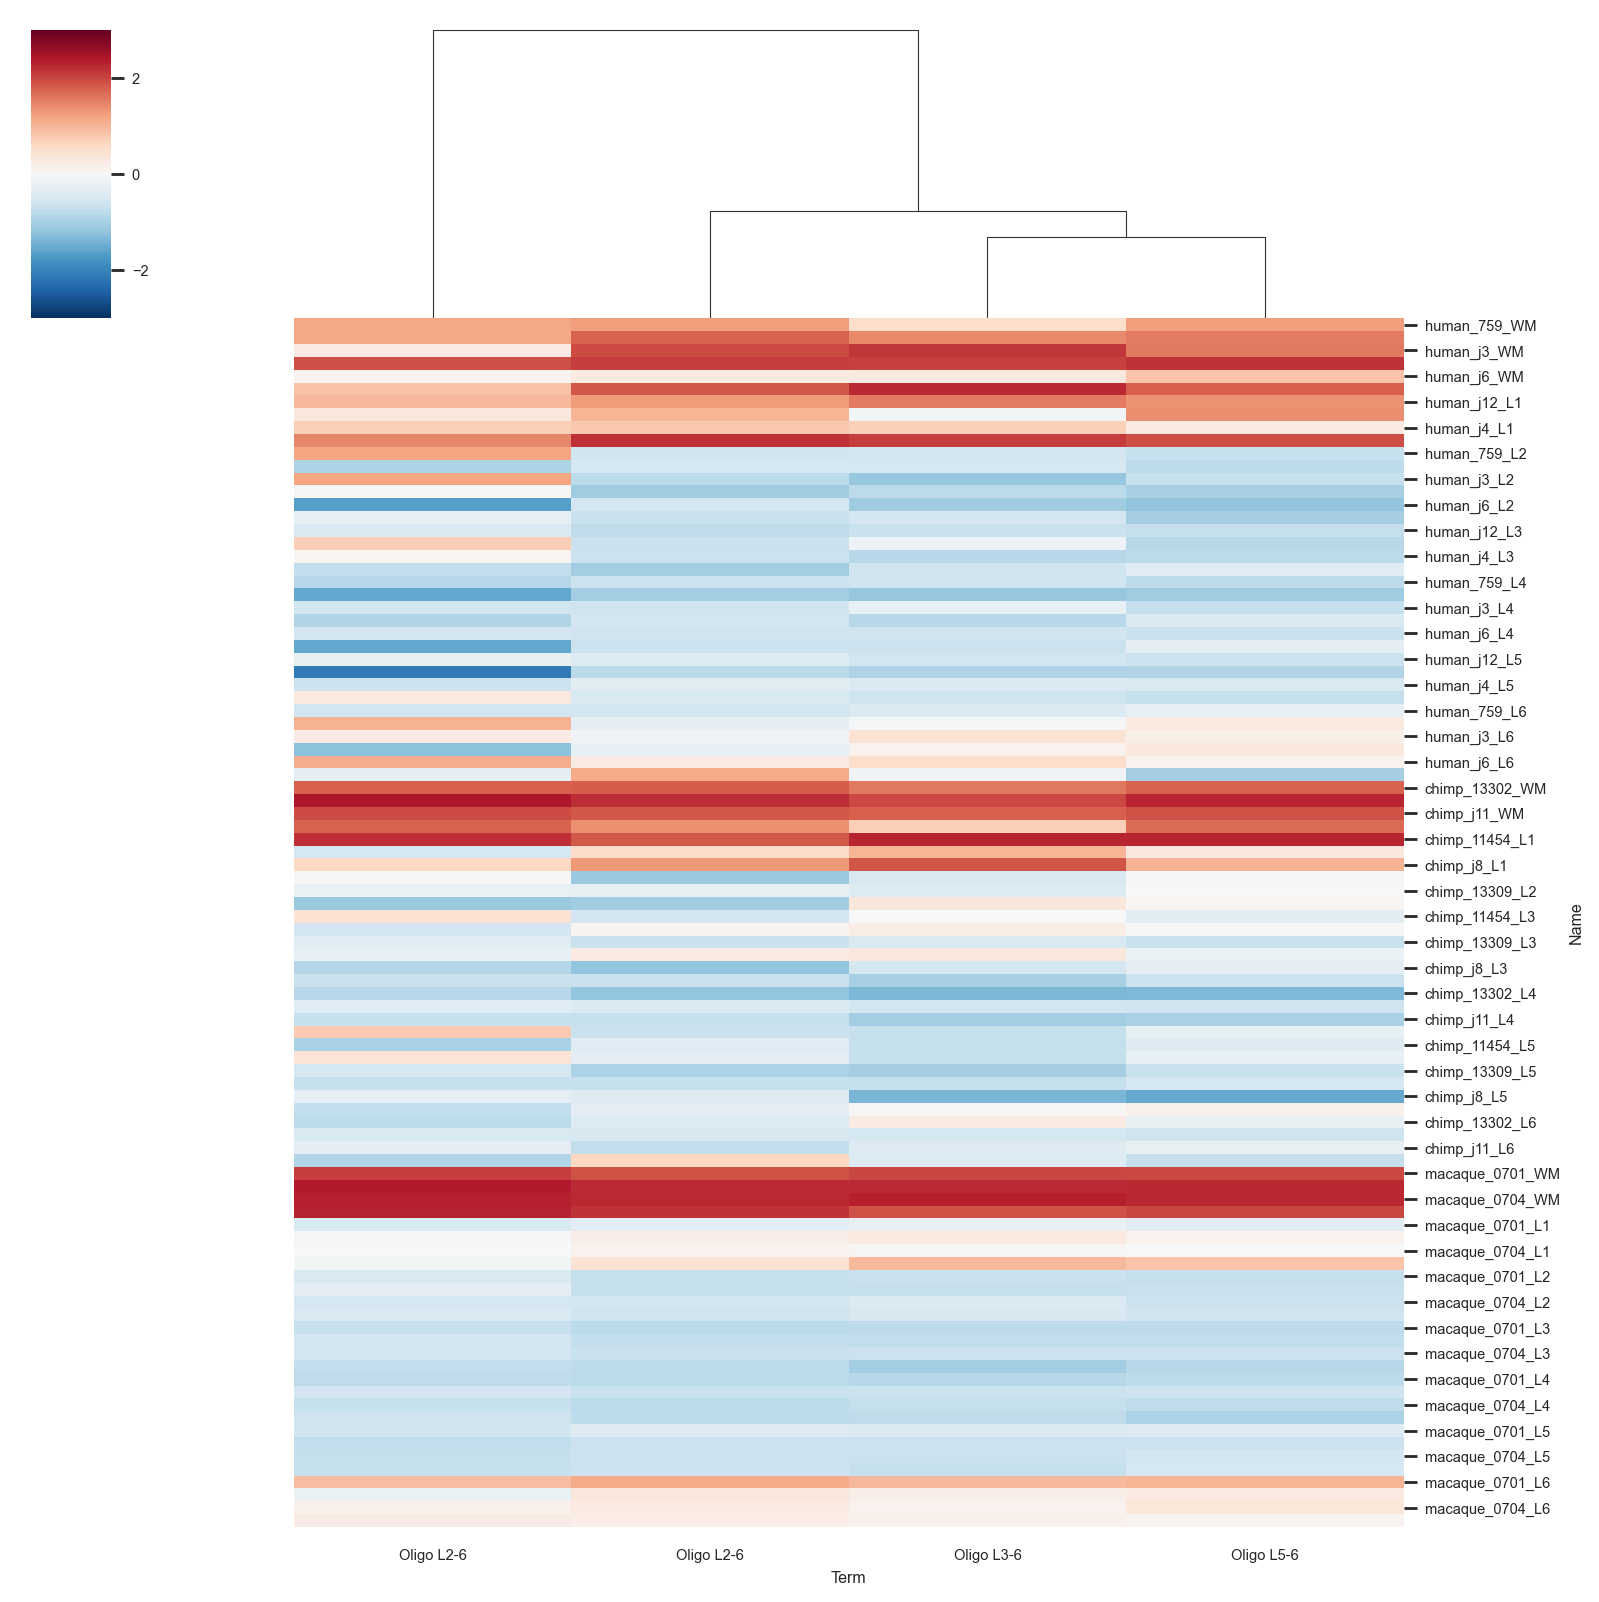

In [41]:
for ct, ax in zip(cell_type, axes):
    sns.set(font_scale=0.6)
    celltype_ord = nes_zscore.columns.str.contains(ct)
    df_sub = nes_zscore.loc[:, celltype_ord].copy()
    df_sub.columns = df_sub.columns.map(lambda x: ' '.join(x.split(' ')[1:3]))
    sns.clustermap(df_sub, metric='cosine', cmap="RdBu_r", vmax=3, vmin=-3, center=0, row_cluster=False)

sns.set(font_scale=1)